In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [3]:
name_dataset = 'biznes'

### load data

In [4]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(13374, 7)
CPU times: user 3.21 s, sys: 41.4 ms, total: 3.25 s
Wall time: 3.25 s


In [5]:
df = df[df.text!='text']
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/caspian_gas/,NaN,Экономика,Туркменистан хочет протянуть газопровод в Турцию,"Как сообщает агентство РИА ""Новости"", главная ...",Бизнес
1,1999-10-11 12:00:00,https://lenta.ru/news/1999/10/11/daewoo/,NaN,Экономика,Daewoo Motor Co. распродает производство автом...,"Автомобили - единственный род продукции, котор...",Бизнес


### preprocess

* get dates

In [6]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

CPU times: user 93.3 ms, sys: 6.85 ms, total: 100 ms
Wall time: 101 ms


<unknown>:2: DeprecationWarning: invalid escape sequence \d


* clean text

In [7]:
import preprocessing_tools as pr

In [8]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 2.87 s, sys: 23.9 ms, total: 2.89 s
Wall time: 2.89 s


In [9]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/caspian_gas/,NaN,Экономика,Туркменистан хочет протянуть газопровод в Турцию,как сообщает агентство риа новости главная тем...,Бизнес,"[(1999, 10, 06)]",1999,10
1,1999-10-11 12:00:00,https://lenta.ru/news/1999/10/11/daewoo/,NaN,Экономика,Daewoo Motor Co. распродает производство автом...,автомобили единственный род продукции который...,Бизнес,"[(1999, 10, 11)]",1999,10


* cleanedNames

In [10]:
from cleanedNames import KeyProc
cn = KeyProc()

In [11]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 27.8 s, sys: 6.3 ms, total: 27.8 s
Wall time: 27.8 s


* lemmatization

In [12]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 54 s, sys: 73.5 ms, total: 54.1 s
Wall time: 54.1 s


* add docID

In [13]:
df['docID'] = list(range(df.shape[0]))

In [14]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[агентство, риа, новость, главный, тема, встре..."
1,1,1999,10,"[автомобиль, единственный, род, продукция, про..."


In [15]:
print(df.shape)
df.isnull().sum()

(13374, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [16]:
df.year.min()

1999

## model

* prepare

In [17]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 184 ms, sys: 20.1 ms, total: 204 ms
Wall time: 209 ms


In [18]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [19]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

artm.BatchVectorizer(data_path="data/batches/biznes", num_batches=14)
CPU times: user 7.53 s, sys: 379 ms, total: 7.91 s
Wall time: 2.7 s


In [20]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [21]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=a1fc9893-d7b7-48cc-b58e-7d316b2f1f1b, num_entries=11650)

In [22]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [23]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #

#topic 2.........
	SparsityThetaScore: 0.13313144445419312
	SparsityPhiScore: 0.2239801585674286
	PerplexityScore: 3587.484130859375
	time: 0:00:17.476142
#topic 3.........
	SparsityThetaScore: 0.2696276307106018
	SparsityPhiScore: 0.3535163402557373
	PerplexityScore: 3183.846435546875
	time: 0:00:18.292159
#topic 4.........
	SparsityThetaScore: 0.3918049931526184
	SparsityPhiScore: 0.4398571848869324
	PerplexityScore: 2863.408447265625
	time: 0:00:19.778309
#topic 5.........
	SparsityThetaScore: 0.46141767501831055
	SparsityPhiScore: 0.48938682675361633
	PerplexityScore: 2693.093994140625
	time: 0:00:21.312547
#topic 6.........
	SparsityThetaScore: 0.5042744874954224
	SparsityPhiScore: 0.5383705496788025
	PerplexityScore: 2581.830322265625
	time: 0:00:20.881688
#topic 7.........
	SparsityThetaScore: 0.533390998840332
	SparsityPhiScore: 0.5777937769889832
	PerplexityScore: 2482.22998046875
	time: 0:00:20.877040
#topic 8.........
	SparsityThetaScore: 0.5550695657730103
	SparsityPhiScore

In [31]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

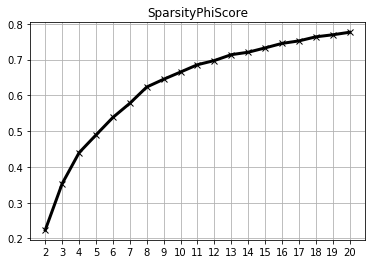

In [24]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [25]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [26]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.2: 1, 0.3: 1, 0.4: 2, 0.5: 2, 0.6: 5, 0.7: 8}

Text(0.5, 1.0, 'SparsityThetaScore')

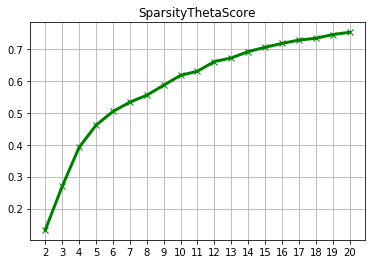

In [27]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [28]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [29]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.1: 1, 0.2: 1, 0.3: 1, 0.4: 1, 0.5: 4, 0.6: 5, 0.7: 6}

Text(0.5, 1.0, 'PerplexityScore')

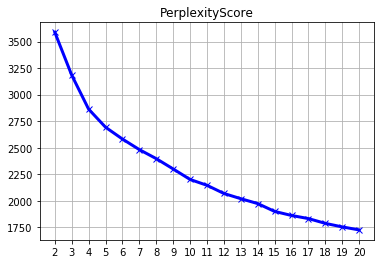

In [30]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [31]:
perplexity

[3587.484130859375,
 3183.846435546875,
 2863.408447265625,
 2693.093994140625,
 2581.830322265625,
 2482.22998046875,
 2397.09716796875,
 2300.073486328125,
 2201.140625,
 2146.06591796875,
 2069.230224609375,
 2019.9208984375,
 1974.031982421875,
 1900.0880126953125,
 1861.9183349609375,
 1832.6527099609375,
 1787.4993896484375,
 1754.2205810546875,
 1725.8880615234375]

### select the best model

In [32]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.2: 1, 0.3: 1, 0.4: 2, 0.5: 2, 0.6: 5, 0.7: 8}
d_stheta: {0.1: 1, 0.2: 1, 0.3: 1, 0.4: 1, 0.5: 4, 0.6: 5, 0.7: 6}


In [33]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

20


---

In [22]:
select_topics = 20

model = artm.ARTM(num_topics=select_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# regularizers
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')

best_model = model.clone()


	SparsityThetaScore: 0.7538357973098755
	SparsityPhiScore: 0.7776094675064087
	PerplexityScore: 1707.42919921875


---

### print top words for each topics

In [23]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['росатом' 'вино' 'атомный' 'алкоголь' 'пиво' 'аэс' 'алкогольный'
 'напиток' 'станция' 'ядерный']
topic_1: ['арбитражный' 'юкос' 'судебный' 'требование' 'банкротство'
 'задолженность' 'налоговый' 'признать' 'долг' 'право']
topic_2: ['оператор' 'автоваз' 'вымпелком' 'модель' 'lada' 'мегафон' 'сотовый'
 'марка' 'мтс' 'абонент']
topic_3: ['фас' 'антимонопольный' 'нарушение' 'ведомство' 'тариф' 'штраф'
 'проверка' 'оператор' 'услуга' 'реклама']
topic_4: ['крым' 'госкорпорация' 'иран' 'оборудование' 'siemens' 'ростёха' 'мост'
 'санкция' 'комплекс' 'техника']
topic_5: ['самолёт' 'вертолёт' 'boeing' 'airbus' 'оак' 'лайнер' 'индия' 'военный'
 'километр' 'двигатель']
topic_6: ['евро' 'французский' 'volkswagen' 'немецкий' 'великобритания'
 'расследование' 'германия' 'франция' 'отзыв' 'дизельный']
topic_7: ['закон' 'письмо' 'проблема' 'власть' 'предложение' 'право' 'министерство'
 'законопроект' 'подчеркнуть' 'орган']
topic_8: ['авиакомпания' 'аэрофлот' 'трансаэро' 'перевозчик' 'пассажир

In [39]:
# save to json

outjson = {}
# ---
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        #print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])
        outjson[f'{col}'] = phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:20]

In [36]:
import pickle

with open(f'''data/top20word/{'-'.join(name_dataset.split('.'))}.pickle''', 'wb') as handle:
    pickle.dump(outjson, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
with open(f'''data/top20word/{'-'.join(name_dataset.split('.'))}.pickle''', 'rb') as handle:
    out_picle = pickle.load(handle)
    
out_picle

{'topic_0': array(['росатом', 'вино', 'атомный', 'алкоголь', 'пиво', 'аэс',
        'алкогольный', 'напиток', 'станция', 'ядерный', 'водка', 'уголь',
        'акциз', 'электроэнергия', 'русгидро', 'литр', 'энергетика',
        'егаиса', 'электростанция', 'марка'], dtype=object),
 'topic_1': array(['арбитражный', 'юкос', 'судебный', 'требование', 'банкротство',
        'задолженность', 'налоговый', 'признать', 'долг', 'право',
        'претензия', 'арест', 'бывший', 'взыскание', 'кредитор',
        'обратиться', 'имущество', 'счёт', 'рассмотрение', 'инстанция'],
       dtype=object),
 'topic_2': array(['оператор', 'автоваз', 'вымпелком', 'модель', 'lada', 'мегафон',
        'сотовый', 'марка', 'мтс', 'абонент', 'выпуск', 'бренд', 'ford',
        'легковой', 'мобильный', 'автопроизводитель', 'автозавод',
        'автомобильный', 'motors', 'toyota'], dtype=object),
 'topic_3': array(['фас', 'антимонопольный', 'нарушение', 'ведомство', 'тариф',
        'штраф', 'проверка', 'оператор', 'усл

### get topics-docs matrix

shape theta: (20, 13374)


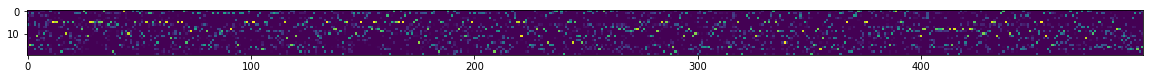

In [24]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [25]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.166006,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.753921,0.001130,0.069199,0.000000,0.000000,0.009745
1,0.000000,0.000000,0.493023,0.0,0.0,0.000000,0.313387,0.000000,0.0,0.056450,0.000000,0.0,0.125635,0.000000,0.011505,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.0,0.0,0.759524,0.000000,0.174138,0.0,0.000000,0.048005,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.018333,0.000000,0.000000
3,0.000000,0.082900,0.000000,0.0,0.0,0.000000,0.015257,0.134199,0.0,0.111693,0.000000,0.0,0.234952,0.030957,0.000000,0.268474,0.000000,0.121568,0.000000,0.000000
4,0.036382,0.106084,0.248310,0.0,0.0,0.000000,0.066100,0.305128,0.0,0.000000,0.000000,0.0,0.015719,0.000000,0.000000,0.192333,0.000000,0.000000,0.029945,0.000000


## DataViz

In [26]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.753921,0.001130,0.069199,0.000000,0.000000,0.009745
1,1,1999,10,0.000000,0.000000,0.493023,0.0,0.0,0.000000,0.313387,...,0.000000,0.0,0.125635,0.000000,0.011505,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,1999,10,0.000000,0.000000,0.000000,0.0,0.0,0.759524,0.000000,...,0.048005,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.018333,0.000000,0.000000
3,3,1999,10,0.000000,0.082900,0.000000,0.0,0.0,0.000000,0.015257,...,0.000000,0.0,0.234952,0.030957,0.000000,0.268474,0.000000,0.121568,0.000000,0.000000
4,4,1999,10,0.036382,0.106084,0.248310,0.0,0.0,0.000000,0.066100,...,0.000000,0.0,0.015719,0.000000,0.000000,0.192333,0.000000,0.000000,0.029945,0.000000


In [27]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (227, 20)


topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
year month                                                               
1999 9      0.000000  1.156982  0.030777  0.119241  0.076993  0.000000   
     10     0.119676  1.141301  0.741333  0.069667  0.000000  0.865733   
     11     0.428161  0.759549  0.148182  0.161305  0.521377  0.561600   
     12     0.361779  2.450089  0.008109  2.084952  0.386860  0.000000   
2000 1      0.000000  0.000000  0.661822  0.000000  0.098692  0.000000   

             topic_6   topic_7   topic_8   topic_9  topic_10  topic_11  \
year month                                                               
1999 9      0.425138  1.702585  0.000000  0.292515  0.132423  0.562098   
     10     0.780073  1.474221  0.574545  0.541905  0.504962  0.532335   
     11     0.382068  1.943658  0.430532  1.902868  0.543170  2.631712   
     12     0.828864  3.720503  0.063673  2.202159  2.037286  1.377321   
2000 1      0.100905  0.962106  0.000000  0.742085  0.168453  0.107360   

            topic_12  topic_13  topic_14  topic_15  topic_16  topic_17  \
year month                                                               
1999 9      0.393825  0.489920  0.901131  0.077773  1.385004  0.108841   
     10     0.697036  0.908134  1.547093  0.573206  0.596371  0.754506   
     11     0.208987  0.460200  1.817208  0.053903  0.101591  0.471997   
     12     0.400719  0.273817  0.125115  0.065020  0.587715  0.762560   
2000 1      0.008668  0.022994  0.000000  0.196540  0.364180  0.378711   

            topic_18  topic_19  
year month                      
1999 9      0.000000  0.144756  
     10     0.415037  0.162868  
     11     0.136542  0.335389  
     12     0.325202  0.938258  
2000 1      0.131953  0.055530

### straightforward matrix heatmap

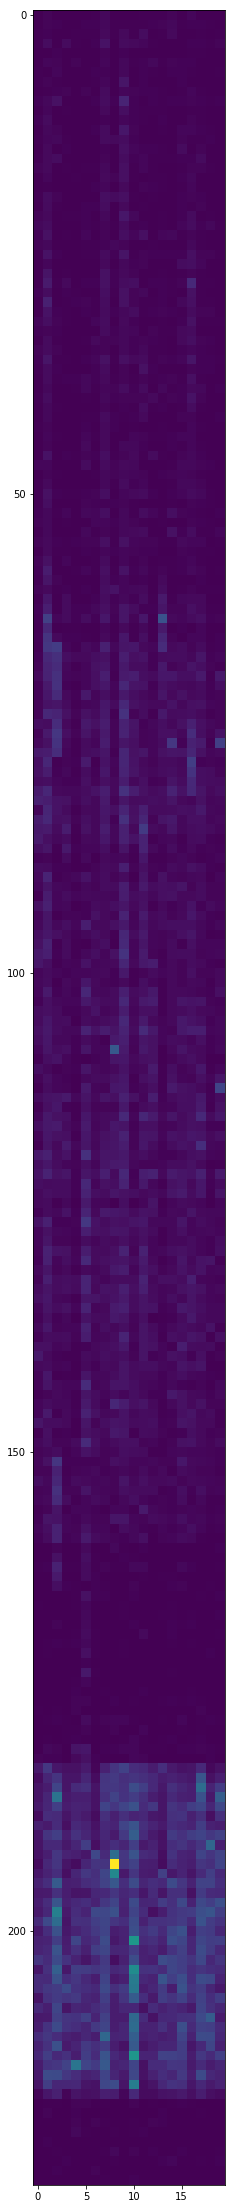

In [28]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [40]:
import pygal
from IPython.display import SVG, HTML

In [41]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [ ]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [44]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [45]:
import joypy # !pip install joypy

In [29]:
print(joined.shape)
joined.head()

(13374, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.753921,0.001130,0.069199,0.000000,0.000000,0.009745
1,1,1999,10,0.000000,0.000000,0.493023,0.0,0.0,0.000000,0.313387,...,0.000000,0.0,0.125635,0.000000,0.011505,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,1999,10,0.000000,0.000000,0.000000,0.0,0.0,0.759524,0.000000,...,0.048005,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.018333,0.000000,0.000000
3,3,1999,10,0.000000,0.082900,0.000000,0.0,0.0,0.000000,0.015257,...,0.000000,0.0,0.234952,0.030957,0.000000,0.268474,0.000000,0.121568,0.000000,0.000000
4,4,1999,10,0.036382,0.106084,0.248310,0.0,0.0,0.000000,0.066100,...,0.000000,0.0,0.015719,0.000000,0.000000,0.192333,0.000000,0.000000,0.029945,0.000000


In [30]:
joined.to_csv(f'''./data/topicsProbability/{'-'.join(name_dataset.split('.'))}.csv''',index=False)

In [47]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,year_month
0,0,0,1999,10,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.732384,0.032341,0.038963,0.006544,0.000000,0.010801,1999-10-01
1,1,1,1999,10,0.000000,0.000000,0.520941,0.000000,0.0,0.055171,...,0.0,0.194949,0.000000,0.024388,0.000000,0.000000,0.000000,0.000000,0.000000,1999-10-01
2,2,2,1999,10,0.000000,0.000000,0.000000,0.000000,0.0,0.779128,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.025760,0.000000,0.000000,1999-10-01
3,3,3,1999,10,0.000000,0.095988,0.000000,0.040459,0.0,0.000000,...,0.0,0.293537,0.061034,0.000000,0.255669,0.000000,0.126978,0.000000,0.000000,1999-10-01
4,4,4,1999,10,0.047216,0.098633,0.226716,0.000000,0.0,0.000000,...,0.0,0.028579,0.000000,0.000000,0.173412,0.000000,0.000000,0.040584,0.000000,1999-10-01


In [48]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(320976, 3)


,year_month,topic,text
0,1999-10-01,index,0.0
1,1999-10-01,index,1.0
2,1999-10-01,index,2.0
3,1999-10-01,index,3.0
4,1999-10-01,index,4.0


In [49]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(267480, 3)


topic_19    13374
topic_8     13374
topic_3     13374
topic_7     13374
topic_14    13374
topic_6     13374
topic_4     13374
topic_5     13374
topic_2     13374
topic_9     13374
topic_18    13374
topic_17    13374
topic_0     13374
topic_10    13374
topic_11    13374
topic_16    13374
topic_1     13374
topic_15    13374
topic_13    13374
topic_12    13374
Name: topic, dtype: int64

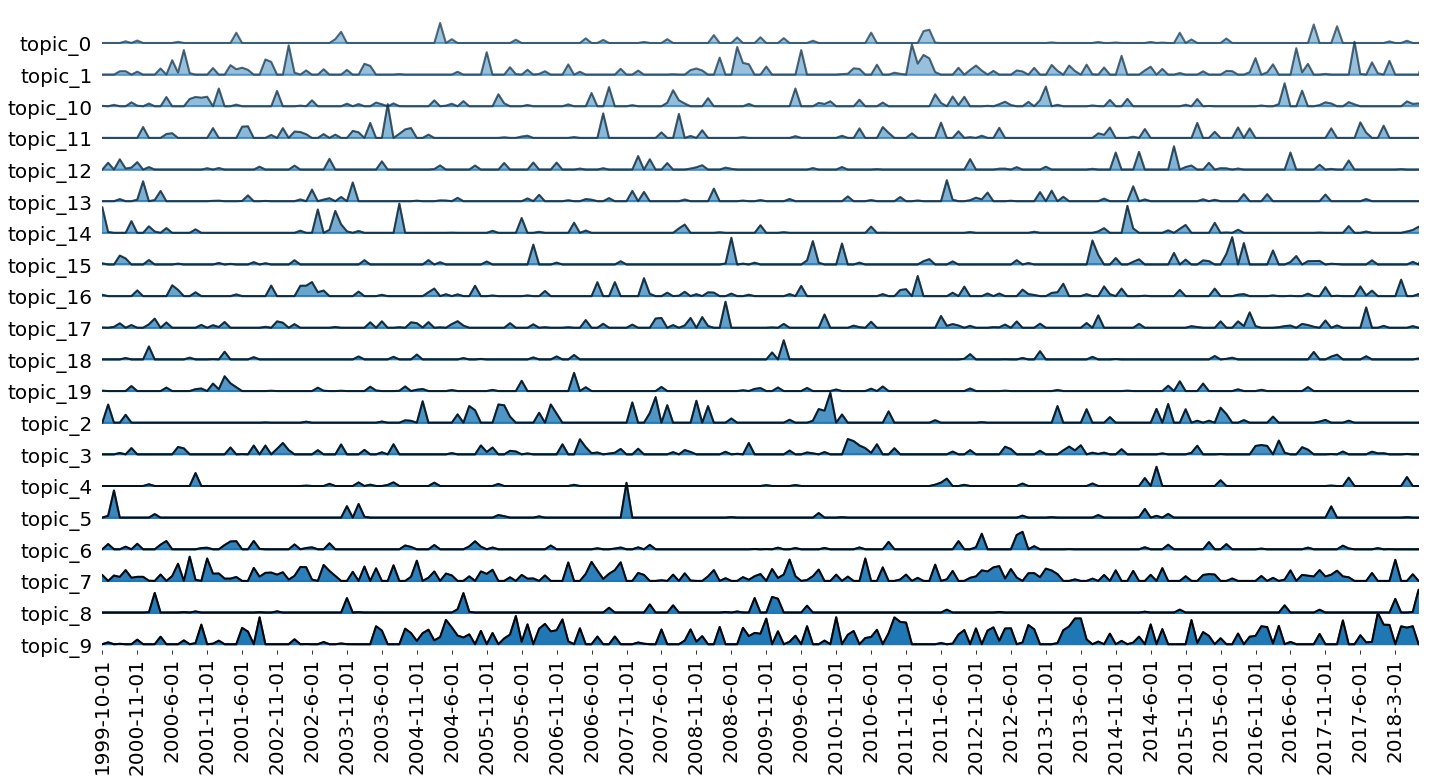

In [50]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [51]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")